**New York City Taxi Fares Prediction**

Features:
•pickup_datetime: a value indicating when the taxi trip starts

•pickup_longitude : for the longitude coordinates where the taxi journey starts

•pickup_latitude : for the latitude coordinates where the taxi journey starts

•dropoff_longitude : for the longitude coordinates where the taxi trip ends

•dropoff_latitude : for the latitude coordinates where the taxi trip ends

•passenger_count : shows the number of passengers who took the taxi

•fare_amount : dollar amount of the cost of a taxi ride. This value is only present in the training set; this is what you predicted in the test set and is required in your submission CSV.

**A. Import Library**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import xgboost as xgb
import math
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

**B. Data Input & Preprocessing**

In [2]:
data_path = os.getcwd()
train_data_path = data_path + '/kaggle/input/taxi_fare_train.csv'
test_data_path = data_path + '/kaggle/input/taxi_fare_test.csv'



In [5]:
df = pd.read_csv("sample_submission.csv")
test = pd.read_csv("sample_submission.csv")
df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35
...,...,...
9909,2015-05-10 12:37:51.0000002,11.35
9910,2015-01-12 17:05:51.0000001,11.35
9911,2015-04-19 20:44:15.0000001,11.35
9912,2015-01-31 01:05:19.0000005,11.35


In [6]:
df.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [7]:
df.describe()

,fare_amount
count,9.914000e+03
mean,1.135000e+01
std,1.833293e-12
min,1.135000e+01
25%,1.135000e+01
50%,1.135000e+01
75%,1.135000e+01
max,1.135000e+01


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          9914 non-null   object 
 1   fare_amount  9914 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.0+ KB


**C. Feature Engineering**

**a) Added distance_traveled feature**

In [9]:
#Function to get distance in kilomerters using pickup and dropoff longitudes and latitudes using haversine formula
def haversine(lat1, lon1, lat2, lon2):
    
  # convert decimal degrees to radians 
  lon1=np.deg2rad(lon1.to_numpy())
  lat1=np.deg2rad(lat1.to_numpy())
  lon2=np.deg2rad(lon2.to_numpy())
  lat2=np.deg2rad(lat2.to_numpy())

  # haversine formula 
  dlon = lon2 - lon1 
  dlat = lat2 - lat1 
  a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
  c = 2 * np.arcsin(np.sqrt(a)) 
  r = 6372.8 # Radius of earth in kilometers
  return np.around(c * r, decimals=2) 

**b) Decomposition of the pickup_datetime feature**

In [10]:
#Adding New Features Using 'pickup_datetime' column
df['pickup_datetime'] = pd.to_datetime(df["pickup_datetime"])
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['date'] = df['pickup_datetime'].dt.day
df['day'] = df['pickup_datetime'].dt.dayofweek
df['hours'] = df['pickup_datetime'].dt.hour
df.drop('pickup_datetime',axis = 1,inplace = True)
df.drop('key',axis = 1,inplace = True)

# Adding peak_hours as [18,19,20]
df['peak_hours'] = df['hours'].apply(lambda x: 1 if x in [18,19,20] else 0)


#Adding 'distance_travelled' column extracted using haversine function
df['distance_travelled'] = haversine(df['pickup_latitude'],df['pickup_longitude'],\
                                            df['dropoff_latitude'],df['dropoff_longitude'])

KeyError: 'pickup_datetime'

In [ ]:
df.describe()
df.info()

**D. Data Cleansing**

In [11]:
'''Function to Clean Following types of Messy data
1 - Drop Nan Value
2 - Drop negative,zero and fare amount over 200$
3 - Drop No of Passengers <= 0 and >= 7
4 - Drop outliers in longitudes,latitudes and distance
5 - Drop Key
'''
def clean_data(df):
    new_df = df[
        ((df['fare_amount'] > 0) & (df['fare_amount'] <= 200)) &
        ((df['pickup_longitude'] > -75) & (df['pickup_longitude'] < -73)) & 
        ((df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42)) &
        ((df['dropoff_longitude'] > -75) & (df['dropoff_longitude'] < -73)) & 
        ((df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42)) & 
        ((df['passenger_count'] > 0) & (df['passenger_count'] <= 6)) &
        ((df['distance_travelled'] > 0) & (df['distance_travelled'] <= 200))
        
    ]
    return new_df

In [12]:
print("Length Before Cleaning: ",len(df))
df = clean_data(df)
print("Length After Cleaning: ",len(df))

Length Before Cleaning:  9914


KeyError: 'pickup_longitude'

In [13]:
df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35
...,...,...
9909,2015-05-10 12:37:51.0000002,11.35
9910,2015-01-12 17:05:51.0000001,11.35
9911,2015-04-19 20:44:15.0000001,11.35
9912,2015-01-31 01:05:19.0000005,11.35


**E. Exploratory Data Analysis**

C:\Users\baniy\anaconda3\lib\site-packages\seaborn\matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\baniy\anaconda3\lib\site-packages\seaborn\matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


<AxesSubplot:title={'center':'Correlation Heatmap'}>

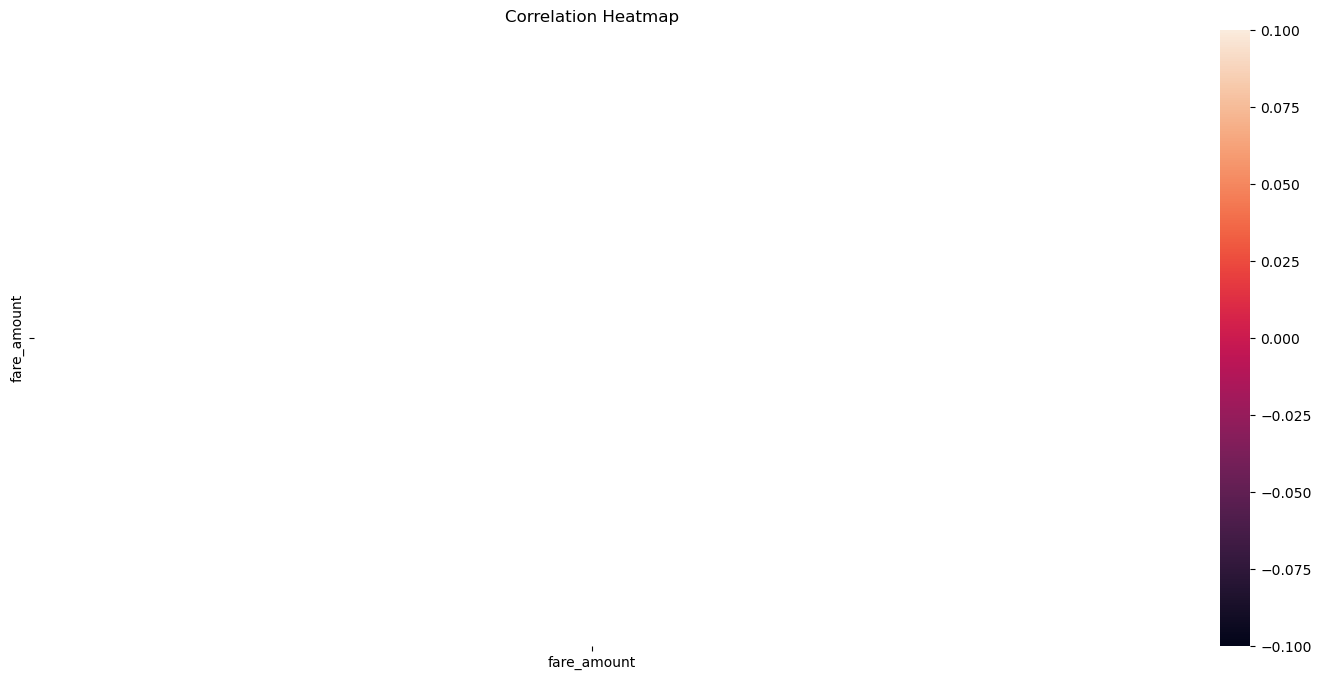

In [14]:
plt.figure(figsize = (18,8))
plt.title('Correlation Heatmap')
corr = df.corr()
corr
sns.heatmap(corr, annot = True)

**a) Number of Passengers for Each Taxi Departure**

In [15]:
#Histogram of the Number of Passengers for Each Taxi Departure
df.passenger_count.hist(bins = 15,figsize=(13,5))
plt.xlabel('Total passenger')
plt.title('Histogram of the Number of Passengers for Each Taxi Departure')

AttributeError: 'DataFrame' object has no attribute 'passenger_count'

**b) Amount of Fare Paid for Each Taxi Departure**

Text(0.5, 1.0, 'Histogram of the Number of Fares Paid for Each Taxi Departure')

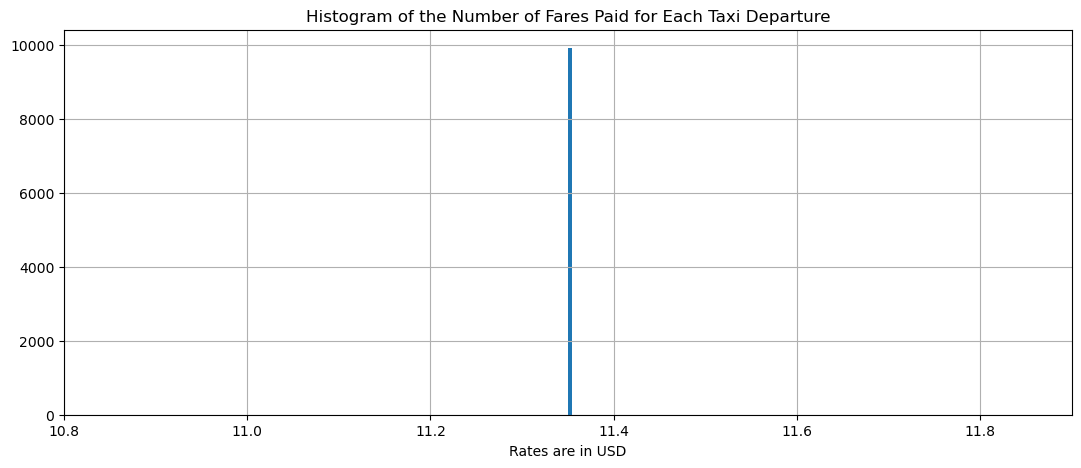

In [16]:
#Histogram of Total Rates
df.fare_amount.hist(bins = 200,figsize = (13,5))
plt.xlabel('Rates are in USD')
plt.title('Histogram of the Number of Fares Paid for Each Taxi Departure')

**c) Total Hourly Rate**

In [17]:
#Amount of Hourly Rates
plt.figure(figsize = (10,5))
new_df = df.groupby('hours', as_index = False)['fare_amount'].agg(['count']).sort_values(by = 'hours', ascending = True)
ax = sns.barplot(x=new_df.index, y=new_df['count'])
ax.set(xlabel='O clock', ylabel='Tariff Amount')  
plt.title('Total Hourly Rate')
plt.tight_layout()
plt.show()

KeyError: 'hours'

<Figure size 1000x500 with 0 Axes>

**F. Machine Learning Algorithms**

In [18]:
#Splitting Data  
df_x = df.drop(['fare_amount'],axis = 1)
df_y = df['fare_amount'].copy()

#Taking 20% data as Test data
x_train,x_test,y_train,y_test = train_test_split(df_x,df_y,test_size = 0.2,random_state = 42)

In [19]:
results_df = pd.DataFrame(columns = ['Name','Mean Absolute Error','Root Mean Square Error'])

def results(name,prediction,test):
    global results_df
    #Mean Absolute Error
    print(name)
    mae = metrics.mean_absolute_error(test, prediction)
    print('Mean Absolute Error:', mae)
    
    #Root Mean Squared Error
    rmse = np.sqrt(metrics.mean_squared_error(test, prediction))
    print('Root Mean Squared Error:', rmse)
    
    results_df = results_df.append({'Name':name,"Mean Absolute Error":mae,"Root Mean Square Error":rmse},ignore_index = True)
    

**a) Linear Regression**

In [20]:
scaler = StandardScaler()
model = linear_model.LinearRegression()
pipe = Pipeline(steps=[('scaler', scaler), ('model', model)], memory = 'tmp')

pipe.fit(x_train,y_train)
prediction = pipe.predict(x_test)

results("Linear Regression",prediction,y_test)

ValueError: could not convert string to float: '2011-11-30 23:09:47.0000003'

**b) XGBOOST**

In [21]:
scaler = StandardScaler()
model = xgb.XGBRegressor(n_estimators = 200,learning_rate = 0.1,max_depth = 5)
pipe = Pipeline(steps=[('scaler', scaler), ('model', model)], memory = 'tmp')
pipe.fit(x_train,y_train)
prediction = pipe.predict(x_test)

results("XGBoost",prediction,y_test)

ValueError: could not convert string to float: '2011-11-30 23:09:47.0000003'

In [22]:
df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35
...,...,...
9909,2015-05-10 12:37:51.0000002,11.35
9910,2015-01-12 17:05:51.0000001,11.35
9911,2015-04-19 20:44:15.0000001,11.35
9912,2015-01-31 01:05:19.0000005,11.35


In [23]:
#Fitur Importances XGBOOST
importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='black', align='center')
plt.yticks(range(len(indices)), [x_train.columns[i] for i in indices])
plt.xlabel('Feature Importance')

NotFittedError: need to call fit or load_model beforehand

**G. Visualization of Algorithm Performance Results**

**a) Mean Absolute Error**

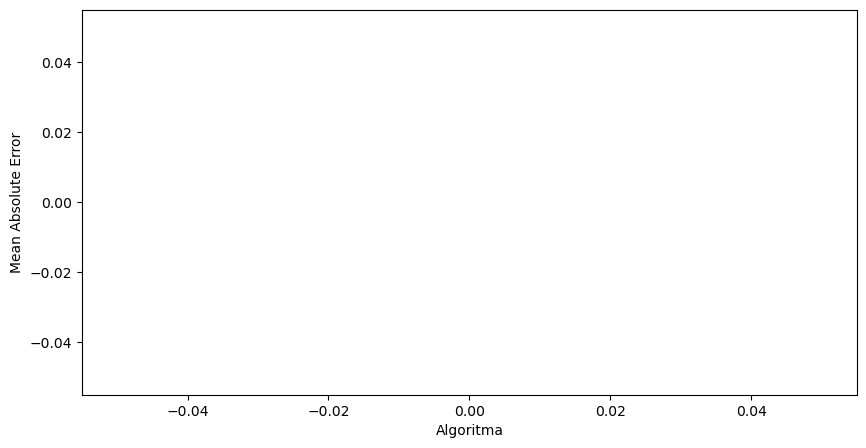

In [24]:
fig = plt.figure(figsize = (10,5))
plt.bar(results_df['Name'],results_df['Mean Absolute Error'],color = 'pink')
plt.xlabel('Algoritma')
plt.ylabel('Mean Absolute Error')
plt.show()

**b) Root Mean Square Error**

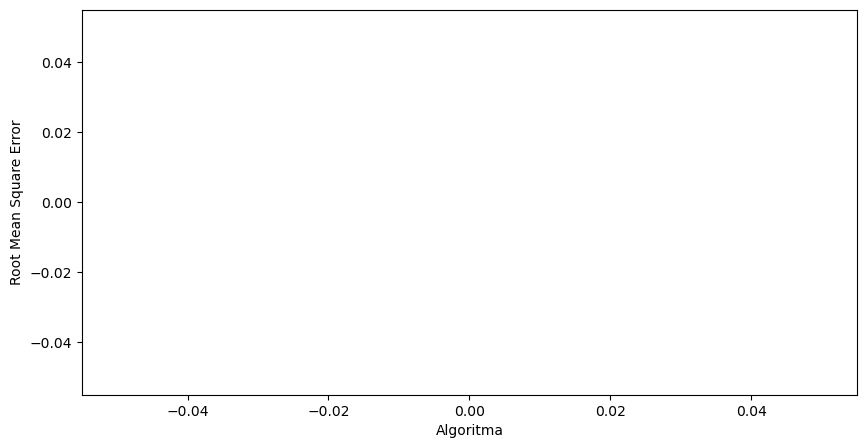

In [25]:
fig = plt.figure(figsize = (10,5))
plt.bar(results_df['Name'],results_df['Root Mean Square Error'],color = 'purple')
plt.xlabel('Algoritma')
plt.ylabel('Root Mean Square Error')
plt.show()

In [26]:
df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35
...,...,...
9909,2015-05-10 12:37:51.0000002,11.35
9910,2015-01-12 17:05:51.0000001,11.35
9911,2015-04-19 20:44:15.0000001,11.35
9912,2015-01-31 01:05:19.0000005,11.35


In [27]:
test = pd.read_csv("C:/Users/chint/Desktop/ML Final Project/new-york-city-taxi-fare-prediction/test.csv")
test

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/chint/Desktop/ML Final Project/new-york-city-taxi-fare-prediction/test.csv'

In [28]:
#Adding New Features Using 'pickup_datetime' column
test['pickup_datetime'] = pd.to_datetime(test["pickup_datetime"])
test['year'] = test['pickup_datetime'].dt.year
test['month'] = test['pickup_datetime'].dt.month
test['date'] = test['pickup_datetime'].dt.day
test['day'] = test['pickup_datetime'].dt.dayofweek
test['hours'] = test['pickup_datetime'].dt.hour
test_x = test.drop('pickup_datetime',axis = 1,inplace = True)


# Adding peak_hours as [18,19,20]
test['peak_hours'] = test['hours'].apply(lambda x: 1 if x in [18,19,20] else 0)


#Adding 'distance_travelled' column extracted using haversine function
test['distance_travelled'] = haversine(test['pickup_latitude'],test['pickup_longitude'],\
                                            test['dropoff_latitude'],test['dropoff_longitude'])
test

KeyError: 'pickup_datetime'

In [29]:
test_x = test.copy()
test_x.drop('key',axis = 1,inplace = True)

In [30]:
test_x

,fare_amount
0,11.35
1,11.35
2,11.35
3,11.35
4,11.35
...,...
9909,11.35
9910,11.35
9911,11.35
9912,11.35


In [31]:
scaler = StandardScaler()
model = xgb.XGBRegressor(n_estimators = 200,learning_rate = 0.1,max_depth = 5)
pipe = Pipeline(steps=[('scaler', scaler), ('model', model)], memory = 'tmp')
pipe.fit(df_x,df_y)
prediction = pipe.predict(test_x)

prediction

ValueError: could not convert string to float: '2015-01-27 13:08:24.0000002'

In [32]:
output = pd.DataFrame({'key': test['key'], 'fare_amount': prediction})
output

NameError: name 'prediction' is not defined